# NLP Disasters Mini Project
**Course:** CSCA 5642
**Date:** Dec 2025

In [1]:
# Basic Libs
import pandas as pd
import numpy as np
import string, os, re
os.environ["CUDA_VISIBLE_DEVICES"] = "-1" # Force CPU to avoid CUDA 12.0 errors with RTX 5090

# Plotting Libs
import seaborn as sns
import matplotlib.pyplot as plt

# NLP Libs
import nltk
# NLTK One-Time Downloads
# nltk.download('wordnet')
# nltk.download('stopwords')
# nltk.download('averaged_perceptron_tagger_eng')
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Embedding Libs
from gensim.models import Word2Vec, FastText

# Linear Model Libs
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score

# Neural Network Libs
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam


2025-12-07 19:59:34.689428: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-07 19:59:34.716105: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-07 19:59:35.196258: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
stop_words = set(stopwords.words('english'))
punct_table = str.maketrans('', '', string.punctuation)
lemmatizer = WordNetLemmatizer()

def clean_pos_lemma(text):
    text = re.sub(r'http\S+|www\S+|https\S+', '', text.lower())
    tokens = text.translate(punct_table).split()
    tagged = nltk.pos_tag(tokens)
    return ' '.join(lemmatizer.lemmatize(w, pos=wordnet.ADJ if t.startswith('J')
                                         else wordnet.VERB if t.startswith('V')
                                         else wordnet.NOUN if t.startswith('N')
                                         else wordnet.ADV if t.startswith('R')
                                         else wordnet.NOUN)
                    for w, t in tagged)

def clean_light(text):
    # minimal cleaning; keeps punctuation/hashtags/mentions for n-grams
    return re.sub(r'http\S+|www\S+|https\S+', '', text.lower())

def clean_char_preserve(text):
    # for char n-grams; almost no cleaning
    return text.lower()

CLEANERS = {
    'pos_lemma': clean_pos_lemma,
    'light': clean_light,
    'char_keep': clean_char_preserve,
}

## Data & Preprocessing

In [3]:
class DisasterData:
    def __init__(self, path: str, val_size=0.2, random_state=11):
        full_train = pd.read_csv(f'{path}/train.csv')
        self.test_df = pd.read_csv(f'{path}/test.csv')
        self.train_df, self.val_df = train_test_split(
            full_train, test_size=val_size, random_state=random_state, stratify=full_train['target']
        )
        self._clean_cache = {} 

    def get_split(self, cleaner_name: str):
        """Return cleaned splits for the requested cleaner; caches to avoid recompute."""
        if cleaner_name not in CLEANERS:
            raise ValueError(f'Unknown cleaner {cleaner_name}')
        if cleaner_name not in self._clean_cache:
            fn = CLEANERS[cleaner_name]
            self._clean_cache[cleaner_name] = (
                self.train_df['text'].apply(fn),
                self.val_df['text'].apply(fn),
                self.test_df['text'].apply(fn),
            )
        X_train, X_val, X_test = self._clean_cache[cleaner_name]
        return {
            'X_train': X_train,
            'y_train': self.train_df['target'],
            'X_val': X_val,
            'y_val': self.val_df['target'],
            'X_test': X_test,
            'test_ids': self.test_df['id'],
        }

In [14]:
disaster_data = DisasterData(path='data')
print('Train data shape:', disaster_data.train_df.shape)
print('Validation data shape:', disaster_data.val_df.shape)

Train data shape: (6090, 5)
Validation data shape: (1523, 5)


## Feature EDA

In NLP, our features are our sentences. We should identify key characterists that inform our model architecture decisions. Below I will explore:
1. Sequence Length Distribution: Identify maxlen for RNN
2. Vocabulary size & coverage: Choose num_words and give a sense of embedding dim
3. Embedding dimension & LSTM size: Sanity check for parameters
4. OOV rate with chose num_words

Train length stats:
count    6090.000000
mean       14.855665
std         5.727400
min         1.000000
1%          3.000000
5%          5.000000
10%         7.000000
25%        11.000000
50%        15.000000
75%        19.000000
90%        22.000000
95%        24.000000
99%        27.000000
max        31.000000
Name: text, dtype: float64


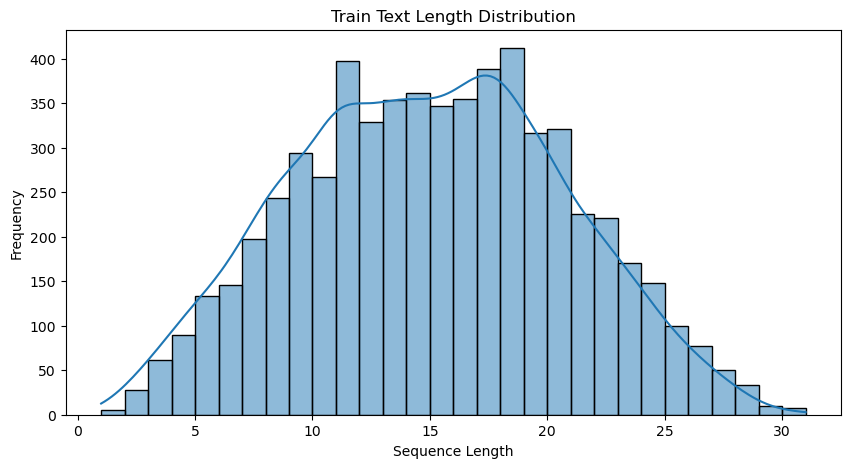

In [11]:
train_lengths = disaster_data.train_df['text'].str.split().str.len()
val_lengths = disaster_data.val_df['text'].str.split().str.len()

print("Train length stats:")
print(train_lengths.describe(percentiles=[0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]))

plt.figure(figsize=(10,5))
sns.histplot(train_lengths, bins=30, kde=True)
plt.title('Train Text Length Distribution')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.show()


Raw vocabulary size: 27033
Words that appear only once: 19758
Words needed to cover 95% of token mass: 22510
Words needed to cover 99% of token mass: 26129


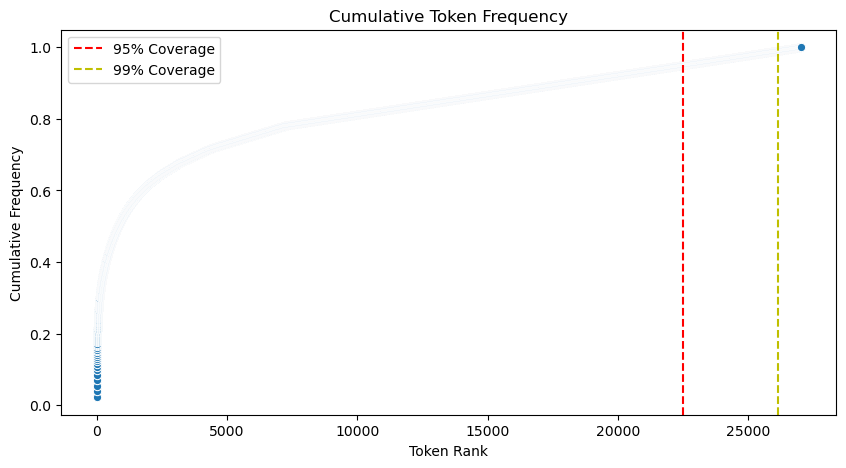

In [16]:
vocab_counts = disaster_data.train_df['text'].str.split().explode().value_counts()
vocab_size = len(vocab_counts)
print(f"Raw vocabulary size: {vocab_size}")

# How many words are extremely rare?
singletons = (vocab_counts == 1).sum()
print(f"Words that appear only once: {singletons}")

# Coverage of token mass
cum_freq = vocab_counts.cumsum() / vocab_counts.sum()
cutoff_95 = np.searchsorted(cum_freq.values, 0.95) + 1
cutoff_99 = np.searchsorted(cum_freq.values, 0.99) + 1

print('Words needed to cover 95% of token mass:', cutoff_95)
print('Words needed to cover 99% of token mass:', cutoff_99)

# Plot cumulative frequency
plt.figure(figsize=(10,5))
sns.lineplot(x=range(len(cum_freq)), y=cum_freq.values, marker='o')
plt.title('Cumulative Token Frequency')
plt.xlabel('Token Rank')
plt.ylabel('Cumulative Frequency')
plt.axvline(cutoff_95, color='r', linestyle='--', label='95% Coverage')
plt.axvline(cutoff_99, color='y', linestyle='--', label='99% Coverage')
plt.legend()
plt.show()

**Embedding dimension & LSTM size**

We can't identify exactly the number of units to use via EDA, but I can:
1. Use the vocab size from #2 to estimate how many parameters we are training.
2. Keep the total parameter count in a reasonable range compared to the datset size.

In [21]:
embedding_dim_range = [50, 100, 200, 300]
lstm_units_range = [32, 64, 128, 256]

for ed in embedding_dim_range:
    for lu in lstm_units_range:
        embedding_params = vocab_size * ed
        lstm_params = 4 * lu * (lu + ed + 1)
        total_params = embedding_params + lstm_params
        print(f"Embedding dim: {ed}, LSTM units: {lu}")
        print(f"Embedding params: {embedding_params:,}")
        print(f"LSTM params: {lstm_params:,}")
        print(f"Total params: {total_params:,}")
        print()

Embedding dim: 50, LSTM units: 32
Embedding params: 1,351,650
LSTM params: 10,624
Total params: 1,362,274

Embedding dim: 50, LSTM units: 64
Embedding params: 1,351,650
LSTM params: 29,440
Total params: 1,381,090

Embedding dim: 50, LSTM units: 128
Embedding params: 1,351,650
LSTM params: 91,648
Total params: 1,443,298

Embedding dim: 50, LSTM units: 256
Embedding params: 1,351,650
LSTM params: 314,368
Total params: 1,666,018

Embedding dim: 100, LSTM units: 32
Embedding params: 2,703,300
LSTM params: 17,024
Total params: 2,720,324

Embedding dim: 100, LSTM units: 64
Embedding params: 2,703,300
LSTM params: 42,240
Total params: 2,745,540

Embedding dim: 100, LSTM units: 128
Embedding params: 2,703,300
LSTM params: 117,248
Total params: 2,820,548

Embedding dim: 100, LSTM units: 256
Embedding params: 2,703,300
LSTM params: 365,568
Total params: 3,068,868

Embedding dim: 200, LSTM units: 32
Embedding params: 5,406,600
LSTM params: 29,824
Total params: 5,436,424

Embedding dim: 200, LSTM 

In [26]:
# OOV Rate with chosen num_words
chosen_num_words = [cutoff_95, cutoff_99]
for nw in chosen_num_words:
    tokenizer = Tokenizer(num_words=nw, oov_token='<OOV>')
    tokenizer.fit_on_texts(disaster_data.train_df['text'])
    
    oov_id = tokenizer.word_index.get('<OOV>')
    total_tokens = 0
    oov_tokens = 0
    for seq in disaster_data.val_df['text'].apply(tokenizer.texts_to_sequences):
        total_tokens += len(seq)
        oov_tokens += sum(1 for t in seq if t == oov_id)
    oov_rate = oov_tokens / total_tokens
    if oov_rate > 1e-3:
        print(f"Num words: {nw}, OOV rate: {oov_rate:.5%}")
    else:
        print(f'Num words: {nw}, Nearly no OOV!')


Num words: 22510, Nearly no OOV!
Num words: 26129, Nearly no OOV!


## TF-IDF Preprocessing + LogReg Baseline

In [4]:
# Baseline model runner
def run_tfidf_logreg(data, tfidf_cfg, logreg_cfg, threshold=None):
    vec = TfidfVectorizer(**tfidf_cfg)
    Xtr = vec.fit_transform(data['X_train'])
    Xval = vec.transform(data['X_val'])

    model = LogisticRegression(**logreg_cfg)
    model.fit(Xtr, data['y_train'])

    val_probs = model.predict_proba(Xval)[:, 1]
    if threshold is None:
        grid = np.linspace(0.3, 0.7, 11)
        f1s = [f1_score(data['y_val'], (val_probs >= t).astype(int)) for t in grid]
        threshold = grid[int(np.argmax(f1s))]
    val_pred = (val_probs >= threshold).astype(int)
    val_f1 = f1_score(data['y_val'], val_pred)
    return {'val_f1': val_f1, 'threshold': threshold, 'model': model, 'vectorizer': vec}

In [ ]:
# Define experiment config and grid
base = {
    'cleaner': 'light',
    'tfidf': {'max_features': 20000, 'ngram_range': (1,2), 'analyzer': 'word'},
    'logreg': {'C': 2.0, 'penalty': 'l2', 'max_iter': 1000, 'class_weight': 'balanced', 'n_jobs': -1},
}
grid = [
    base,
    {**base, 'cleaner': 'char_keep', 'tfidf': {**base['tfidf'], 'analyzer': 'char', 'ngram_range': (3,5)}},
    {**base, 'cleaner': 'pos_lemma'},
]

results = []
artifacts = {}
for cfg in grid:
    split = disaster_data.get_split(cfg['cleaner'])
    res = run_tfidf_logreg(split, cfg['tfidf'], cfg['logreg'])
    name = f"{cfg['cleaner']}_{cfg['tfidf']['analyzer']}_{cfg['tfidf']['ngram_range']}"
    results.append({'name': name, 'val_f1': res['val_f1'], 'threshold': res['threshold']})
    artifacts[name] = (res, split, cfg)

pd.DataFrame(results).sort_values('val_f1', ascending=False)

,name,val_f1,threshold
2,"pos_lemma_word_(1, 2)",0.777117,0.46
1,"char_keep_char_(3, 5)",0.771359,0.54
0,"light_word_(1, 2)",0.767286,0.46


In [6]:
best_name = pd.DataFrame(results).sort_values('val_f1', ascending=False).iloc[0]['name']
res, split, cfg = artifacts[best_name]

# Refit on full train (train+val) with same cleaner/vectorizer settings
full_clean = pd.concat([split['X_train'], split['X_val']])
full_y = pd.concat([split['y_train'], split['y_val']])

vec = TfidfVectorizer(**cfg['tfidf'])
Xfull = vec.fit_transform(full_clean)
model = LogisticRegression(**cfg['logreg'])
model.fit(Xfull, full_y)

Xtest = vec.transform(split['X_test'])
test_pred = (model.predict_proba(Xtest)[:,1] >= res['threshold']).astype(int)

print(f'Best model: {best_name}')
print(f'F1 Score: {res["val_f1"]:.4f}')
print(f'Threshold: {res["threshold"]:.4f}')

# No baseline submission

Best model: pos_lemma_word_(1, 2)
F1 Score: 0.7771
Threshold: 0.4600


## RNN Model (Keras)

In [7]:
tokenizer = Tokenizer(num_words=20000, oov_token='<OOV>')
tokenizer.fit_on_texts(disaster_data.X_train)

X_train_seq = tokenizer.texts_to_sequences(disaster_data.X_train)
X_val_seq = tokenizer.texts_to_sequences(disaster_data.X_val)
X_test_seq = tokenizer.texts_to_sequences(disaster_data.X_test)

maxlen = 40

X_train_pad = pad_sequences(X_train_seq, padding='post', maxlen=maxlen)
X_val_pad = pad_sequences(X_val_seq, padding='post', maxlen=maxlen)
X_test_pad = pad_sequences(X_test_seq, padding='post', maxlen=maxlen)

vocab_size = min(20000, len(tokenizer.word_index) + 1)
embedding_dim = 100

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))

model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=1e-3),
    metrics=['accuracy']
)

model.summary()

AttributeError: 'DisasterData' object has no attribute 'X_train'

In [ ]:
history = model.fit(
    X_train_pad, disaster_data.y_train,
    epochs=3,
    batch_size=64,
    validation_data=(X_val_pad, disaster_data.y_val),
    )

val_pred_prob = model.predict(X_val_pad).ravel()
val_pred = (val_pred_prob >= 0.5).astype(int)
val_f1_rnn = f1_score(disaster_data.y_val, val_pred)
print(f'LSTM F1 Score: {val_f1_rnn:.4f}')

Epoch 1/3
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5703 - loss: 0.6845 - val_accuracy: 0.5706 - val_loss: 0.6855
Epoch 2/3
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6169 - loss: 0.6570 - val_accuracy: 0.7498 - val_loss: 0.5451
Epoch 3/3
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6969 - loss: 0.5637 - val_accuracy: 0.5673 - val_loss: 0.6588
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
LSTM F1 Score: 0.6451


### Kaggle Submission

In [ ]:
test_pred_prob = model.predict(X_test_pad).ravel()
test_pred = (test_pred_prob >= 0.5).astype(int)

disaster_data.submission = pd.DataFrame({
    'id': disaster_data.test_df.id,
    'target': test_pred
})
disaster_data.submission.to_csv('submission.csv', index=False)

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


## Error Analysis

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

mis_idx = np.where(val_pred != disaster_data.y_val)[0][:3]

for i in mis_idx:
    text_i = disaster_data.X_val_raw.iloc[i]
    vec_i = X_val_tfidf[i]

    # find nearest neighbors in training set
    sims = cosine_similarity(vec_i, X_train_tfidf).ravel()
    top_idx = sims.argsort()[-3:][::-1]

    print('--- Misclassified Text ---')
    print('Text:', text_i)
    print('Pred:', val_pred[i])
    print('True:', disaster_data.y_val.iloc[i])
    print('Nearest Neighbors:')
    for idx in top_idx:
        print(f'Text: {disaster_data.X_train_raw.iloc[idx]}')
    print()

--- Misclassified Text ---
Text: @Blizzard_draco @LoneWolffur I need this.
Pred: 1
True: 0
Nearest Neighbors:
Text: @Blizzard_draco @LoneWolffur also me please I would very much like a link
Text: @LoneWolffur control yourself tora
Text: @LoneWolffur BRUH *dies*

--- Misclassified Text ---
Text: #news Politifiact: Harry Reid's '30 Percent of Women Served' Planned Parenthood Claim Is a 'Pants on Fire' Lie... http://t.co/bMSeDZOfSV
Pred: 1
True: 0
Nearest Neighbors:
Text: Politifiact: Harry Reid's '30 Percent of Women Served' Planned Parenthood Claim Is a 'Pants on Fire' Lie http://t.co/aMYMwWcpYm | #tcot
Text: 30 seconds for my bitches to evacuate ??????
Text: @NoahCRothman Bore him with minutiae serve bad champagne. He may just explode.

--- Misclassified Text ---
Text: @mustachemurse @dateswhitecoats the truth. I pulled a 16 out. And apparently a 22 in the crazy adult trauma. And they mocked me for the 22.
Pred: 1
True: 0
Nearest Neighbors:
Text: SCREAMING IN 22 DIFFERENT LANGUAGES htt